# Examples of Fundamental Sentiment Analysis

## Using vaderSentiment for sentiment analysis

In this example, we will use the package vaderSentiment to do a simple sentiment analysis using the messages on StockTwits. The data file used is "Stocktwits_Samples.csv". Please download the file from Learn and upload to your own folder in Google Drive and try the example.

In [1]:
import os
import random
import tqdm
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.python import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras import backend as K

from keras.layers import Dense, Embedding, SimpleRNN
from keras.models import Sequential
from scipy import stats

from pprint import pprint
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('precision', 4)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import *
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

# These options determine the way floating point numbers are displayed.
np.set_printoptions(precision=4, suppress=True)

tf.random.set_seed(100)

In [2]:
#### install vaderSentiment ####
!pip install --upgrade vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 2.3 MB/s eta 0:00:00


In [21]:
#### Reading some stocktwits message data ####
#### https://stocktwits.com/ ####
'''
stocktwits stops its API services for downloading their message data from 2020, 
it's quite hard to obtain more message from this platform
'''
### READ DATASET ###

from google.colab import drive

# mount the Google drive as a path that you can work on 
drive.mount('/drive')
# !!!! the file path always starts with '/drive/My Drive/', you must change this to locate your file directory !!!!
# using 'ISO-8859-1' is to avoid encoding error from utf-8 (message from web is very noisy and messy with unusual characteristics)
df = pd.read_csv('/drive/My Drive/Colab Notebooks/Data/Stocktwits_Samples.csv', parse_dates=['timestamp'], encoding='ISO-8859-1')
df.head()

# remove the non-ASCII in text column
for i in df.index:
    string_encode = df.loc[i,'text'].encode("ascii", "ignore")
    df.loc[i,'text'] = string_encode.decode()

# keep useful columns
stocktwits_messages = df[['timestamp','id','text','symbols','company_names']]

print(stocktwits_messages.shape, '\n')
stocktwits_messages.head()

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
(28439, 5) 



,timestamp,id,text,symbols,company_names
0,Wed Jul 18 21:33:26 +0000 2018,1.0197E+18,VIDEO: ??I was in my office. I was minding my ...,GS,The Goldman Sachs
1,Wed Jul 18 22:22:47 +0000 2018,1.01971E+18,The price of lumber $LB_F is down 22% since hi...,M,Macy's
2,Wed Jul 18 22:32:01 +0000 2018,1.01971E+18,Who says the American Dream is dead? https://t...,AIG,American
3,Wed Jul 18 22:52:52 +0000 2018,1.01972E+18,Barry Silbert is extremely optimistic on bitco...,BTC,Bitcoin
4,Wed Jul 18 23:00:01 +0000 2018,1.01972E+18,How satellites avoid attacks and space junk wh...,ORCL,Oracle


In [43]:
# drop the possible na
stocktwits_messages.dropna(inplace=True)

# stocktwits_messages.loc[:,'timestamp'] = pd.to_datetime(stocktwits_messages.loc[:,'timestamp'], format='%a %b %d %H:%M:%S +0000 %Y')

dates = stocktwits_messages.loc[:,'timestamp'].astype('datetime64[ns]')

stocktwits_messages.loc[:,'timestamp'] = dates.values
# 

stocktwits_messages.head()

all_symbols = np.sort( stocktwits_messages['symbols'].unique() )

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


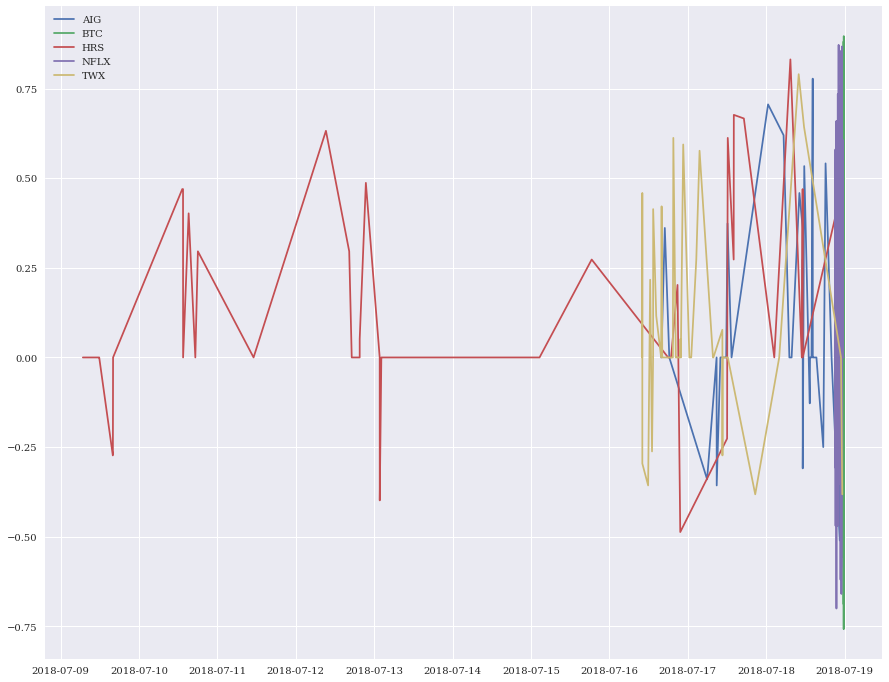

In [44]:
### sentiments ####
all_scores=[]
for idx in stocktwits_messages.index:
    score = analyser.polarity_scores( stocktwits_messages.loc[idx,'text'] )
    all_scores.append(score)

all_scores_df = pd.DataFrame(all_scores)
all_scores_df.head()

# merge the stock and sentiments
data_stock_sentiments = stocktwits_messages.join(all_scores_df )[['timestamp','symbols','neg','neu','pos','compound']]

# take a general look at different stock's sentiment based on the messages
stock_sentiment_average = data_stock_sentiments.groupby(['symbols','timestamp']).mean()

'''
this is the sentiments of each stock over the time period in the dataset,
in practice, you may collect more messages over longer time 
and test the correlation between the sentiments and the stock price or return
'''
plt.figure(figsize=(15,12))
plot_stocks=[]
for stocks in stocktwits_messages['symbols'].unique()[:10]:
    cur_senti_ = stock_sentiment_average.loc[ stocks, 'compound']
    if cur_senti_.shape[0]>3:
        plot_stocks.append(stocks)
        plt.plot(cur_senti_)
plt.legend(plot_stocks)